In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
import os
import matplotlib.pyplot as plt
import yaml

from wire_detector_platforms import WireDetectorCPU

In [2]:
with open('wire_detect_config.yaml', 'r') as file:
    detection_config = yaml.safe_load(file)

# Create a WireDetector instance
input_image_size = [480, 270]

# folder = '/media/tyler/Storage/field_tests/mocap_handheld/'
# target_timestamp = 1752772596420911873 # straight wire
# target_timestamp = 1746650656862302432 # angled wire

# folder = '/media/tyler/Storage/field_tests/acfa_3-21/'
# target_timestamp = 1742581588251564064

folder = '/media/tyler/hummingbird/hawkins_2_19_1/'
target_timestamp = 1739975958352738816 # seperated wires
# target_timestamp = 1739975963786320032 # wires in a bundle
# target_timestamp = 1739975992503588928  # wires clean

rgb_folder = folder + 'rgb_images/'
depth_folder = folder + 'depth_images/'
camera_intrinsics_file = folder + 'rgb_camera_intrinsics.npy'
camera_intrinsics = np.load(camera_intrinsics_file)

closest_rgb_timestamp = None
closest_depth_timestamp = None
for image_name in os.listdir(rgb_folder):
    if image_name.endswith('.png'):
        timestamp = int(image_name.split('.')[0])
        if closest_rgb_timestamp is None or abs(timestamp - target_timestamp) < abs(closest_rgb_timestamp - target_timestamp):
            closest_rgb_timestamp = timestamp
            closest_rgb_timestamp_s = timestamp * 1e-9  # Convert to seconds
for image_name in os.listdir(depth_folder):
    if image_name.endswith('.npy'):
        timestamp = int(image_name.split('.')[0])
        if closest_depth_timestamp is None or abs(timestamp - target_timestamp) < abs(closest_depth_timestamp - target_timestamp):
            closest_depth_timestamp = timestamp
            closest_depth_timestamp_s = timestamp * 1e-9  # Convert to seconds

rgb_image_path = str(closest_rgb_timestamp) + '.png'
depth_image_path = str(closest_depth_timestamp) + '.npy'

print(f"Time difference between closest RGB and depth images: {abs(closest_rgb_timestamp_s - closest_depth_timestamp_s)}")

img = cv2.imread(rgb_folder + rgb_image_path)
depth = np.load(depth_folder + depth_image_path)
assert img is not None, "Image not found"
assert depth is not None, "Depth image not found"

original_image_size = img.shape[:2][::-1]  # (width, height)

# resize the camera intrinsics to match the input image size
camera_intrinsics[0, 0] *= input_image_size[0] / original_image_size[0]
camera_intrinsics[1, 1] *= input_image_size[1] / original_image_size[1]
camera_intrinsics[0, 2] *= input_image_size[0] / original_image_size[0]
camera_intrinsics[1, 2] *= input_image_size[1] / original_image_size[1]

wire_detector = WireDetectorCPU(detection_config, camera_intrinsics)

Time difference between closest RGB and depth images: 0.07602334022521973


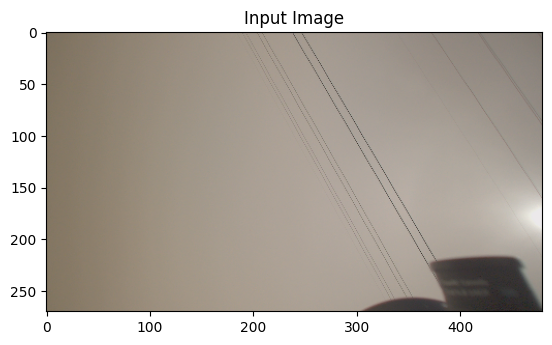

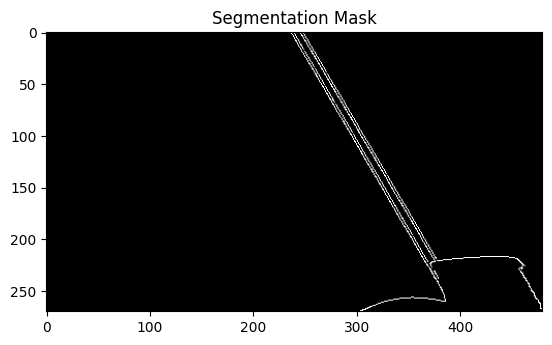

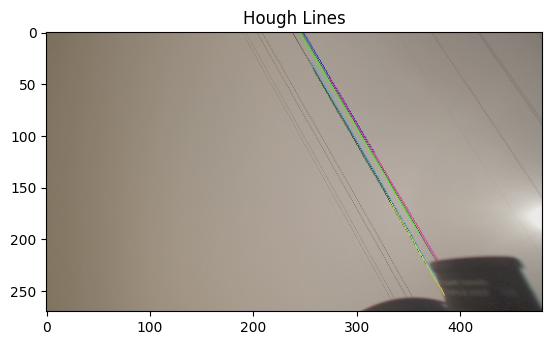

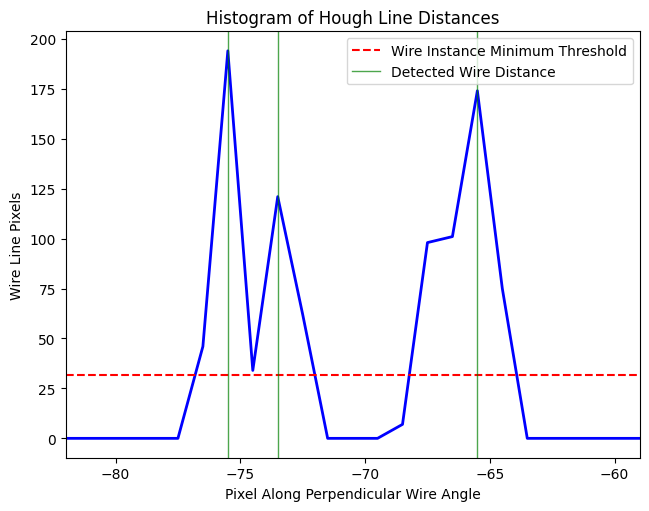

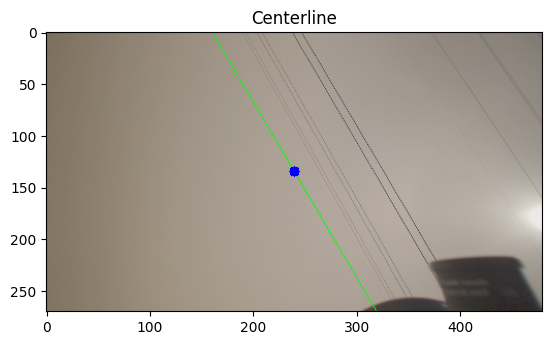

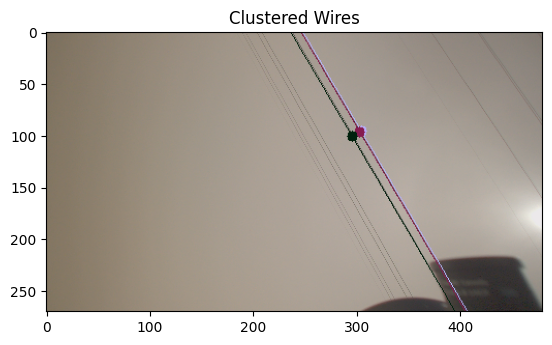

In [3]:
# Create hough folder if it doesn't exist
os.makedirs('hough', exist_ok=True)

img = cv2.resize(img, (input_image_size[0], input_image_size[1]))
cv2.imwrite('hough/reference.jpg', img)
plt.figure()
plt.title('Input Image')
plt.imshow(img)

# Create segmentation mask

# Detect wires using the segmentation mask
hough_lines, seg_mask = wire_detector.get_hough_lines(img)
assert hough_lines is not None, "No lines found"
cv2.imwrite('hough/seg_mask.jpg', seg_mask)
plt.figure()
plt.title('Segmentation Mask')
plt.imshow(seg_mask, cmap='gray')
# Visualize detected wires
hough_img = img.copy()
for x0, y0, x1, y1 in hough_lines:
    rand_color = tuple(np.random.randint(0, 256, 3).tolist())
    cv2.line(hough_img, (x0, y0), (x1, y1), rand_color, 1)
cv2.imwrite('hough/hough_detect.jpg', hough_img)
plt.figure()
plt.title('Hough Lines')
plt.imshow(hough_img)

cartesian_lines, center_line, avg_angle = wire_detector.get_line_candidates(img)

wire_lines, wire_midpoints, hist, bin_edges, bin_threshold, wire_distances_wrt_center = wire_detector.get_line_instance_locations(cartesian_lines, center_line, avg_angle)

nonzero_indices = np.nonzero(hist)[0]
if len(nonzero_indices) > 0:
    xmin = bin_edges[nonzero_indices[0]]
    xmax = bin_edges[nonzero_indices[-1] + 1]  # +1 to include the end of the last bin
else:
    xmin, xmax = bin_edges[0], bin_edges[-1]  # fallback if all zero

plt.figure()
plt.plot(
    bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2, hist,
    color='b', linewidth=2)

# Threshold line
plt.axhline(
    bin_threshold, color='r', linestyle='--', label='Wire Instance Minimum Threshold')

# Wire distances
first = True
for dist in wire_distances_wrt_center:
    plt.axvline(
        x=-dist, color='g', linestyle='-', linewidth=1, alpha=0.7, label='Detected Wire Distance' if first else None)
    first = False
plt.tight_layout()
plt.title('Histogram of Hough Line Distances')
plt.xlabel('Pixel Along Perpendicular Wire Angle')
plt.ylabel('Wire Line Pixels')

plt.xlim(xmin - 5, xmax + 5)

plt.legend(loc='best')  # Automatically places legend in a non-overlapping position
plt.savefig('hough/histogram.png')

centerline_img = img.copy()
cv2.line(centerline_img, (center_line[0], center_line[1]), (center_line[2], center_line[3]), (0, 255, 0), 1)
cv2.circle(centerline_img, (int(wire_detector.cx), int(wire_detector.cy)), 5, (0, 0, 255), -1)
cv2.imwrite('hough/centerline.jpg', centerline_img)
plt.figure()
plt.title('Centerline')
plt.imshow(centerline_img)

clustered_img = img.copy()
rand_colors = np.random.randint(0, 256, (len(wire_midpoints), 3)).tolist()
for i, (x0,y0,x1,y1) in enumerate(wire_lines):
    cv2.line(clustered_img, (x0,y0), (x1,y1), tuple(rand_colors[i]), 1)

for i, (x0,y0) in enumerate(wire_midpoints):
    cv2.circle(clustered_img, (int(x0), int(y0)), 5, tuple(rand_colors[i]), -1)

cv2.imwrite('hough/cluster_detect.jpg', clustered_img)
plt.figure()
plt.title('Clustered Wires')
plt.imshow(clustered_img)
